## Imports

In [1]:
import bilby
import gwpopulation as gwpop
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import seaborn as sns
import corner
import glob

from astropy import cosmology, units
from scipy.interpolate import interp1d

from bilby.core.prior import Uniform, LogUniform, PriorDict, Constraint
from bilby.gw.prior import BBHPriorDict
from gwpopulation.models import mass, spin

xp = gwpop.cupy_utils.xp

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Official Results

In [2]:
result = bilby.core.result.read_in_result("copy1.json")

In [14]:
result.log_bayes_factor

-408.4414422954807

PermissionError: [Errno 13] Permission denied: '/home/shanika.galaudage/projects/gwinference/condor/o3a/population_runs_201126/outdir_o1o2o3_no_190814_low_vt_fixed_redshift/result/o1o2o3_mass_e_iid_mag_two_comp_iid_tilt_powerlaw_redshift_corner.png'

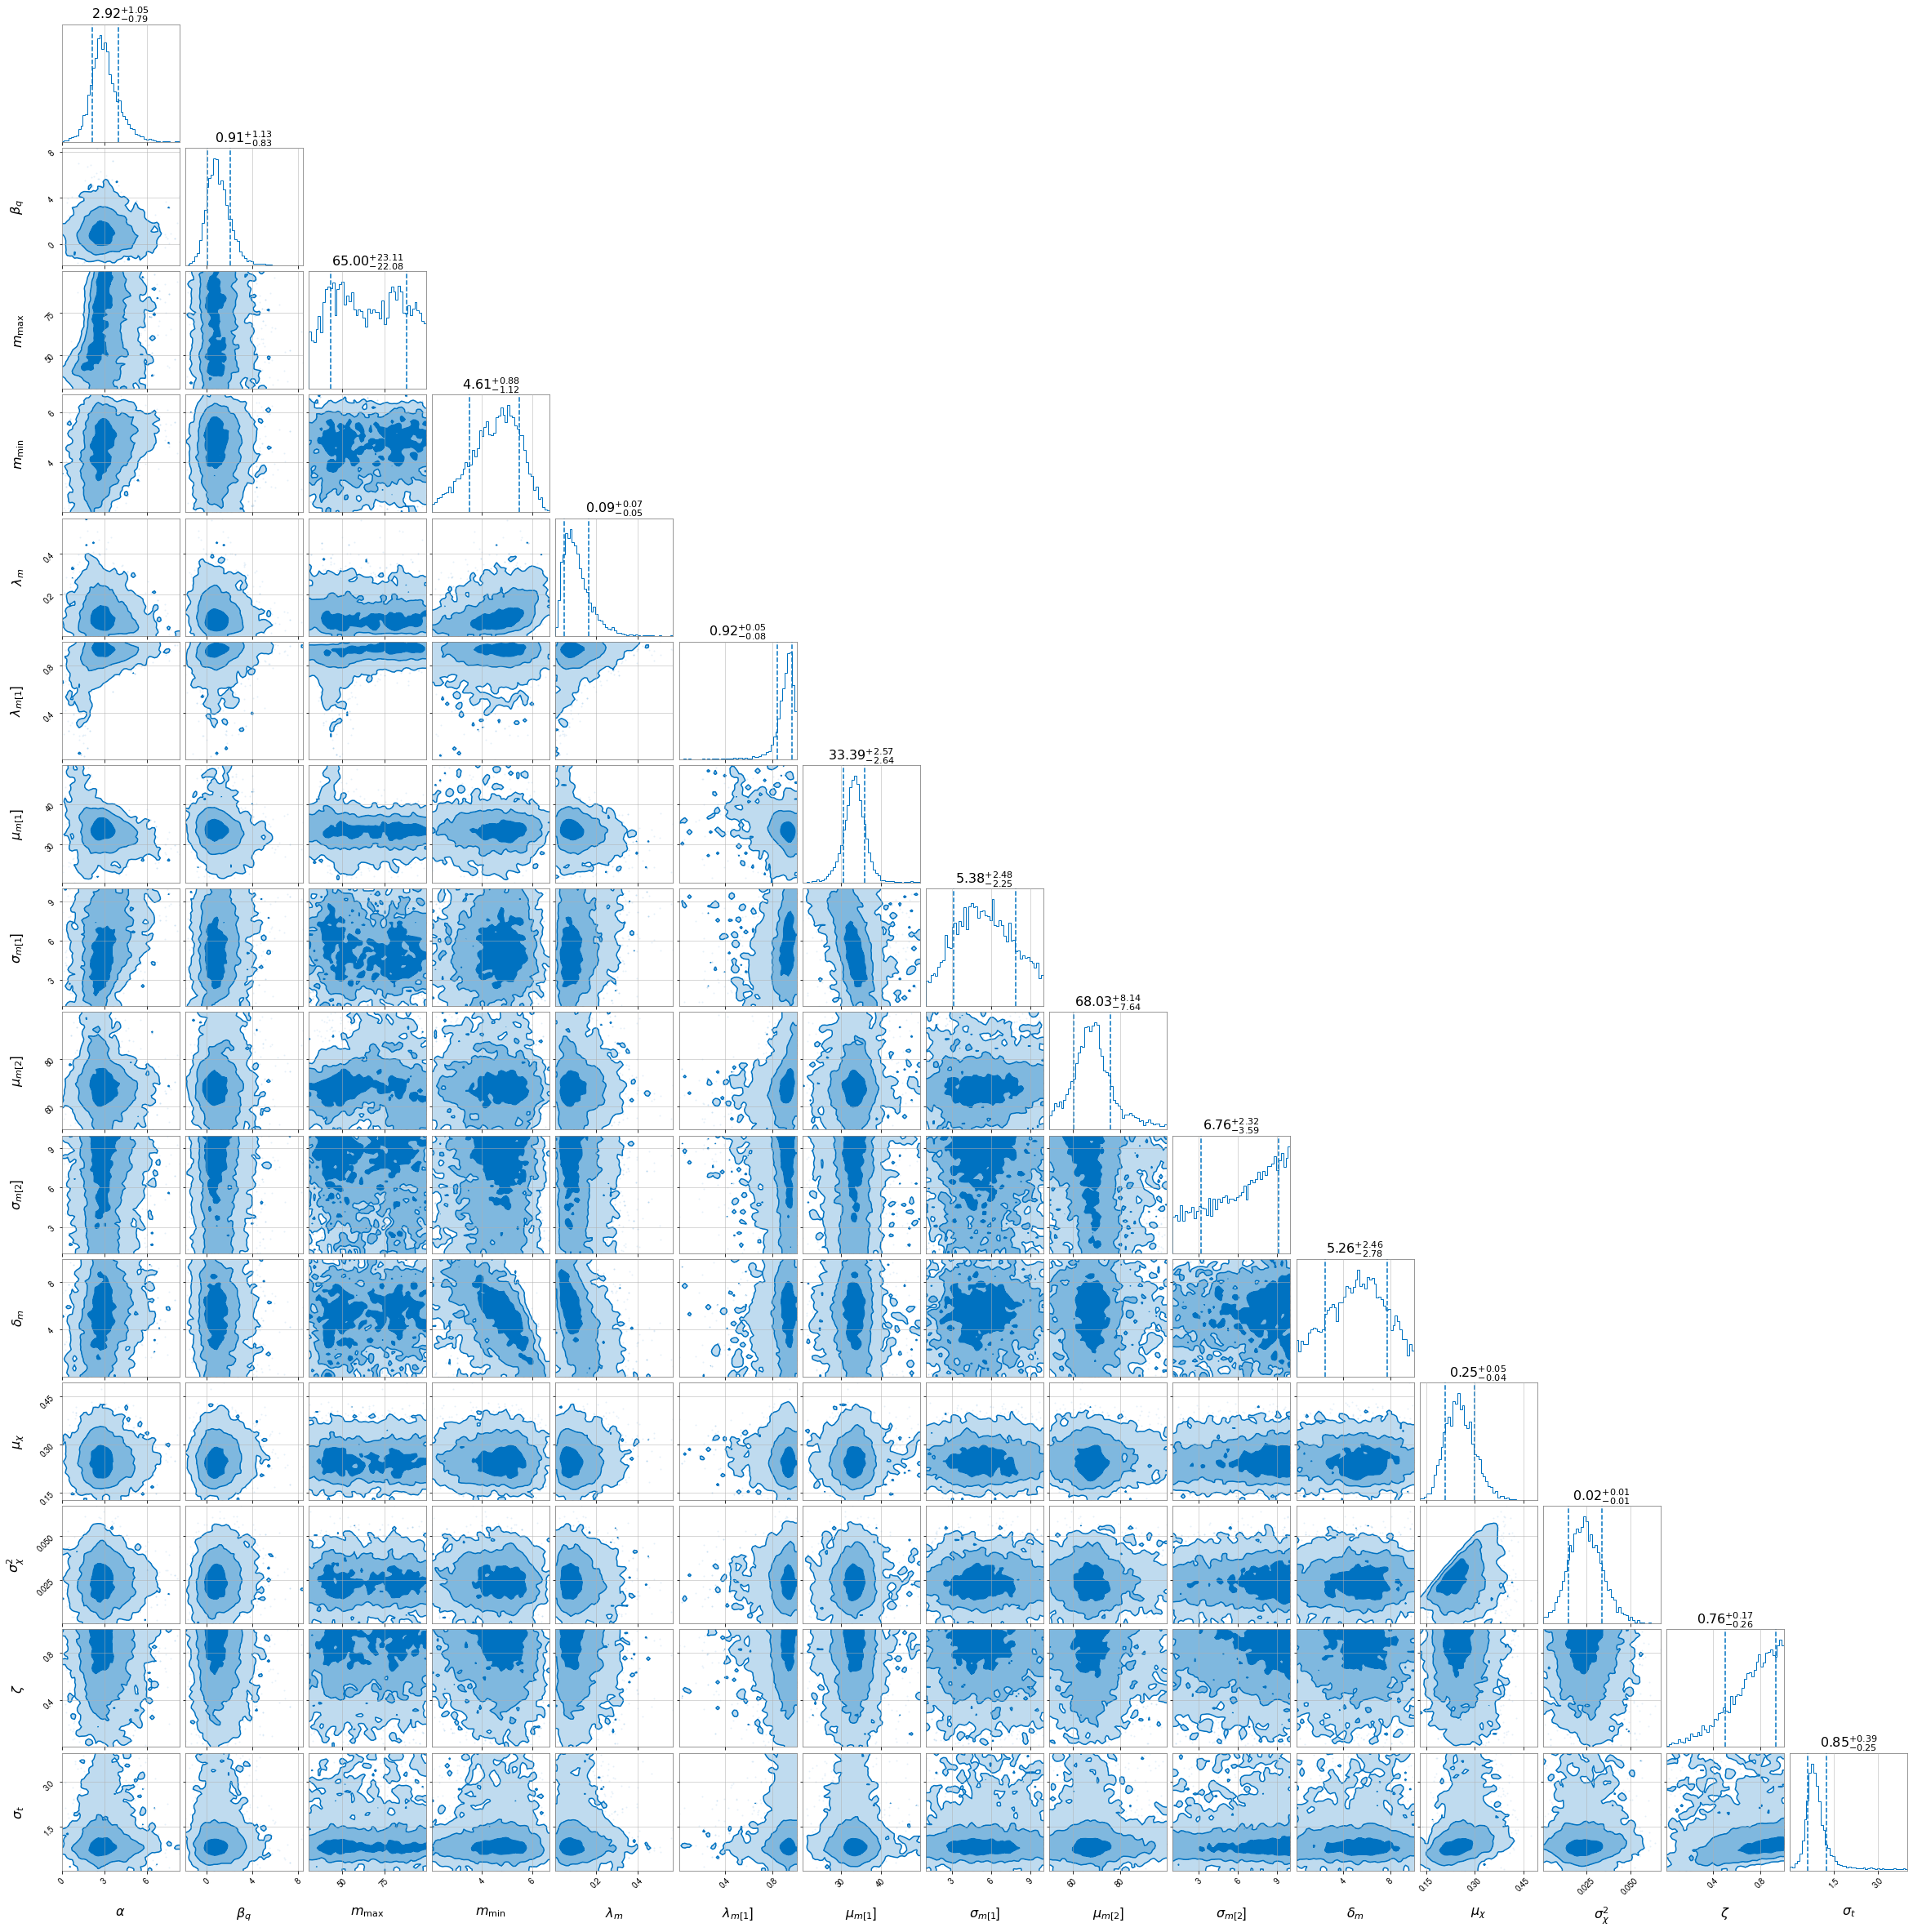

In [15]:
result.plot_corner()

### Posteriors

#### GWTC-1

In [2]:
parameter_translator = dict(
    mass_1_det = 'm1_detector_frame_Msun',
    mass_2_det = 'm2_detector_frame_Msun',
    luminosity_distance = 'luminosity_distance_Mpc',
    a_1 = 'spin1',
    a_2 = 'spin2',
    cos_tilt_1 = 'costilt1',
    cos_tilt_2 = 'costilt2')

In [3]:
posteriors = list()
i = 0

file = 'GWTC-1/GWTC-1_sample_release/GW{}_GWTC-1.hdf5'

events = ['150914', '151012', '151226', '170104', '170608', 
          '170729', '170809', '170814', '170818', '170823']

for event in events:
    print(i, event)
    i = i+1
    _posterior = pd.DataFrame()
    with h5py.File(file.format(event), 'r') as ff:
        for my_key, gwtc_key in parameter_translator.items():
            _posterior[my_key] = ff['IMRPhenomPv2_posterior'][gwtc_key]
    posteriors.append(_posterior)

0 150914
1 151012
2 151226
3 170104
4 170608
5 170729
6 170809
7 170814
8 170818
9 170823


In [4]:
luminosity_distances = np.linspace(1, 10000, 1000)
redshifts = np.array([cosmology.z_at_value(cosmology.Planck15.luminosity_distance, 
                                                   dl * units.Mpc) for dl in luminosity_distances])
dl_to_z = interp1d(luminosity_distances, redshifts)

def chieff(a1, a2, q, cost1, cost2):
    chi_eff = (a1*cost1 + a2*q*cost2)/(1+q)
    return chi_eff

def chiP(a1, a2, q, cost1, cost2):
    q1 = a1 * sin(arccos(cost1))
    q2 = ((4*q + 3)/(4 + 3*q)) * q * a2 * sin(arccos(cost2))
    return np.max([q1, q2], axis = 0)

In [5]:
for posterior in posteriors:
    posterior['redshift'] = dl_to_z(posterior['luminosity_distance'])
    posterior['mass_1'] = posterior['mass_1_det'] / (1 + posterior['redshift'])
    posterior['mass_2'] = posterior['mass_2_det'] / (1 + posterior['redshift'])
    posterior['mass_ratio'] = posterior['mass_2'] / posterior['mass_1']
    posterior['chi_eff'] = chieff(posterior['a_1'], posterior['a_2'], posterior['mass_ratio'],
                                  posterior['cos_tilt_1'], posterior['cos_tilt_2'])
    posterior['chi_p'] = chiP(posterior['a_1'], posterior['a_2'],
                              posterior['mass_ratio'], posterior['cos_tilt_1'], posterior['cos_tilt_2'])
    del posterior["mass_1_det"]
    del posterior["mass_2_det"]

#### GWTC-2

In [6]:
parameter_translator = dict(
    mass_1 = 'mass_1_source',
    mass_2 = 'mass_2_source',
    mass_ratio = 'mass_ratio',
    luminosity_distance = 'luminosity_distance',
    a_1 = 'a_1',
    a_2 = 'a_2',
    cos_tilt_1 = 'cos_tilt_1',
    cos_tilt_2 = 'cos_tilt_2', 
    chi_eff = 'chi_eff', 
    chi_p = 'chi_p', 
    redshift = 'redshift')

In [7]:
j = 0

for file in glob.glob("GWTC-2/GWTC-2_sample_release/S*.h5"):
    print(i, file)
    i = i+1
    with h5py.File(file, 'r') as ff:
        for key in ["C01:NRSur7dq4", "C01:IMRPhenomPv3HM", "C01:IMRPhenomPv2"]:
            print(j)
            j = j+1
            if key in ff.keys():
                _posterior = pd.DataFrame()
                for my_key, gwtc_key in parameter_translator.items():
                    post = ff[key]["posterior_samples"]
                    f = pd.DataFrame(np.array(post))
                    _posterior[my_key] = f[gwtc_key]
            posteriors.append(_posterior)
            break;

10 GWTC-2/GWTC-2_sample_release/S190828j.h5
0
11 GWTC-2/GWTC-2_sample_release/S190727h.h5
1
12 GWTC-2/GWTC-2_sample_release/S190424ao.h5
2
13 GWTC-2/GWTC-2_sample_release/S190731aa.h5
3
14 GWTC-2/GWTC-2_sample_release/S190412m.h5
4
15 GWTC-2/GWTC-2_sample_release/S190706ai.h5
5
16 GWTC-2/GWTC-2_sample_release/S190503bf.h5
6
17 GWTC-2/GWTC-2_sample_release/S190413i.h5
7
18 GWTC-2/GWTC-2_sample_release/S190828l.h5
8
19 GWTC-2/GWTC-2_sample_release/S190514n.h5
9
20 GWTC-2/GWTC-2_sample_release/S190602aq.h5
10
21 GWTC-2/GWTC-2_sample_release/S190413ac.h5
11
22 GWTC-2/GWTC-2_sample_release/S190910s.h5
12
23 GWTC-2/GWTC-2_sample_release/S190708ap.h5
13
24 GWTC-2/GWTC-2_sample_release/S190915ak.h5
14
25 GWTC-2/GWTC-2_sample_release/S190707q.h5
15
26 GWTC-2/GWTC-2_sample_release/S190408an.h5
16
27 GWTC-2/GWTC-2_sample_release/S190519bj.h5
17
28 GWTC-2/GWTC-2_sample_release/S190521r.h5
18
29 GWTC-2/GWTC-2_sample_release/S190701ah.h5
19
30 GWTC-2/GWTC-2_sample_release/S190924h.h5
20
31 GWTC-2/GW

In [8]:
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
import astropy

def LALprior_wt(z):
    d_l = cosmo.luminosity_distance(z).to(u.Mpc).value
    d_c = cosmo.comoving_distance(z).to(u.Mpc).value
    h_z = cosmo.efunc(z) * cosmo.H(0).value
    c = astropy.constants.c.to('km/s').value
    weight = (1+z)**2 * d_l**2 * (d_c + (c * (1+z)) / h_z)
    return weight 

def astro_prior_wt(m1, z):
    mmin = 5
    dVc_dz = cosmo.differential_comoving_volume(z).to(u.Mpc**3/u.sr).value * 4 * pi
    weight = (1+z)**1.7 / (m1 * (m1 - mmin)) * dVc_dz
    return weight

In [9]:
for posterior in posteriors:
    posterior["LALprior"] = LALprior_wt(posterior["redshift"]) 
    posterior["astro_prior"] = astro_prior_wt(posterior["mass_1"], posterior["redshift"])
    posterior["prior"] = posterior["astro_prior"] / (4 * posterior["LALprior"])

In [8]:
# for posterior in posteriors:
#     posterior["prior"] = 1/4

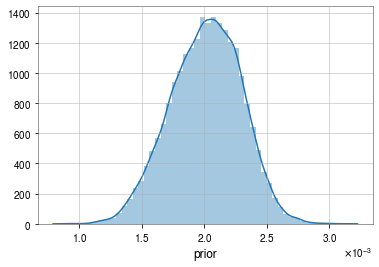

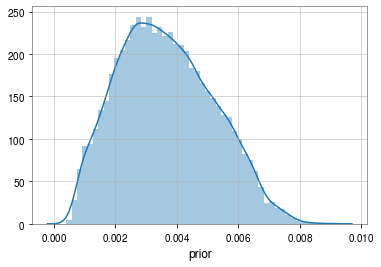

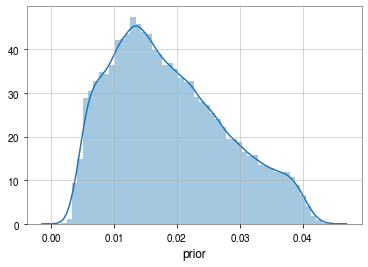

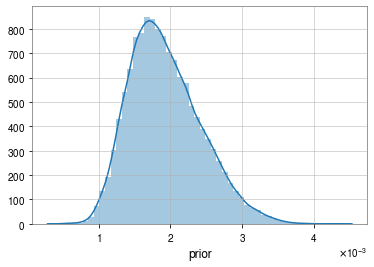

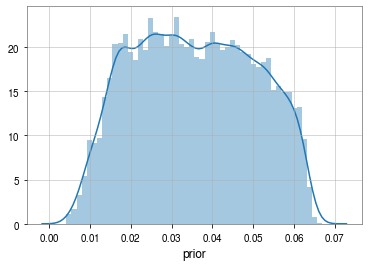

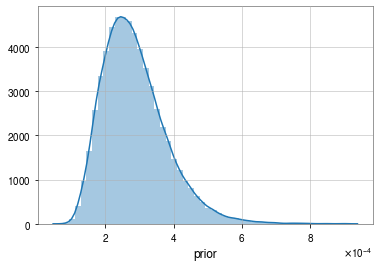

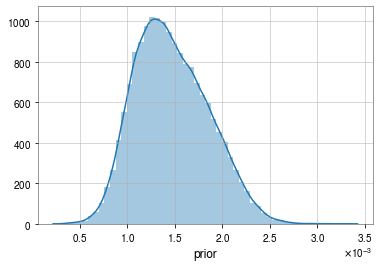

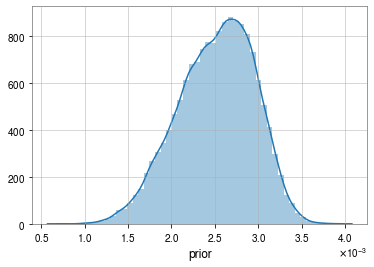

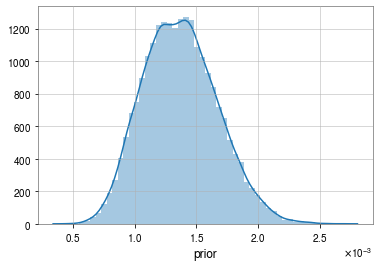

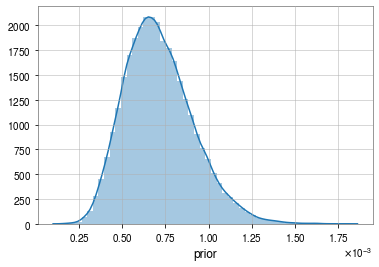

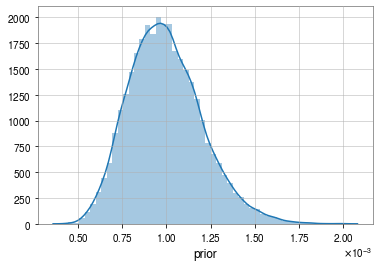

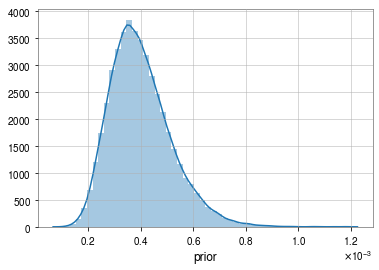

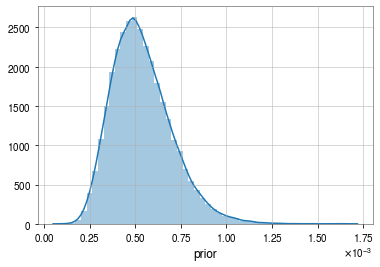

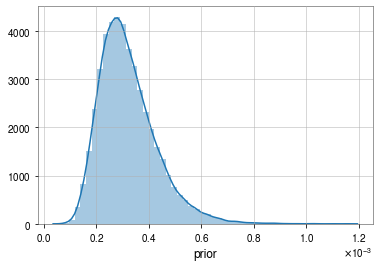

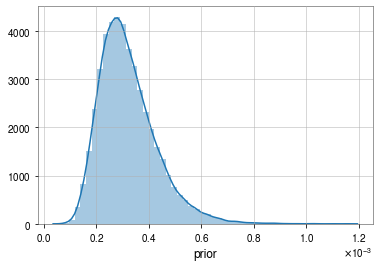

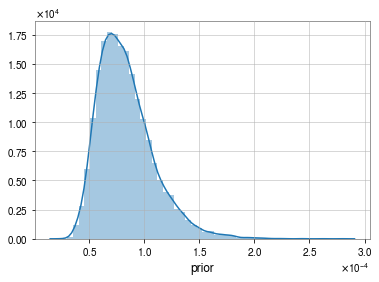

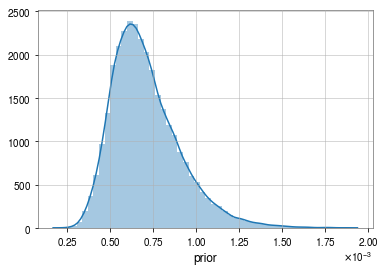

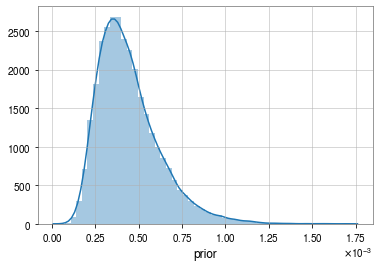

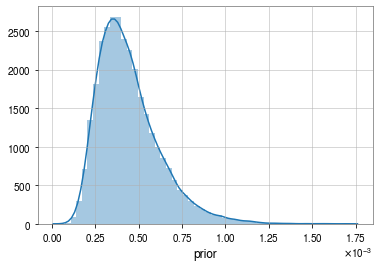

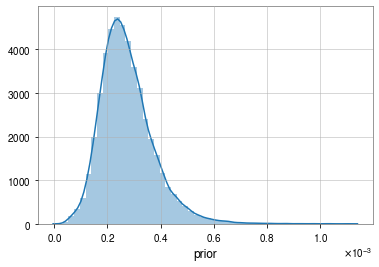

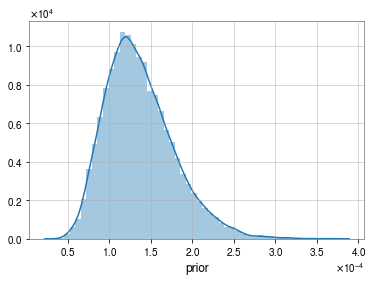

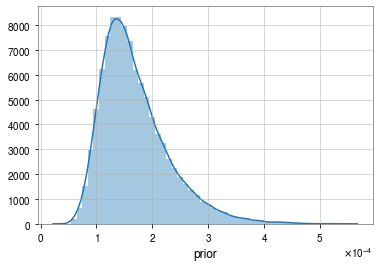

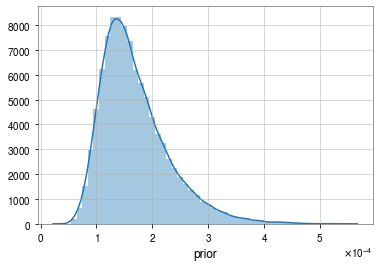

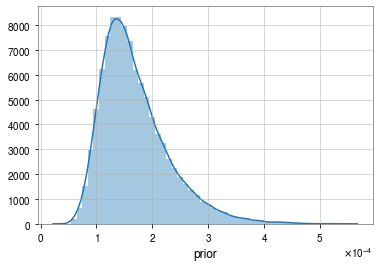

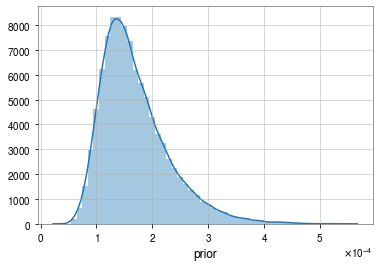

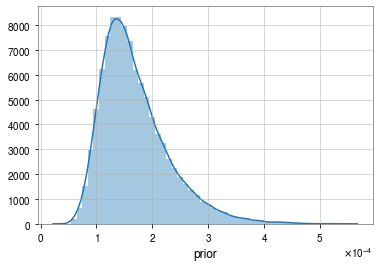

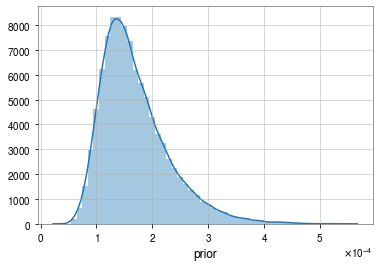

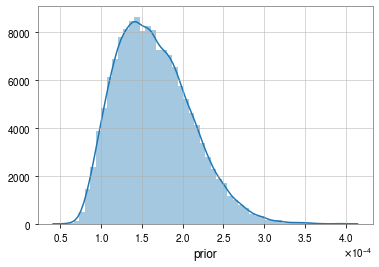

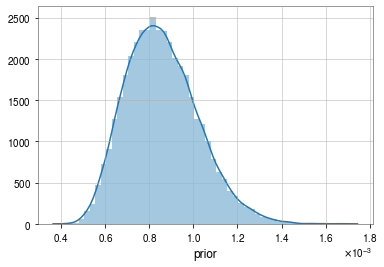

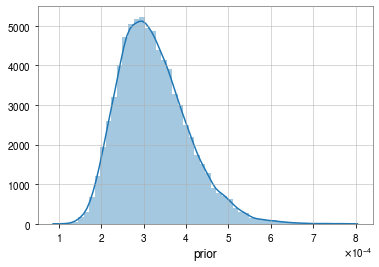

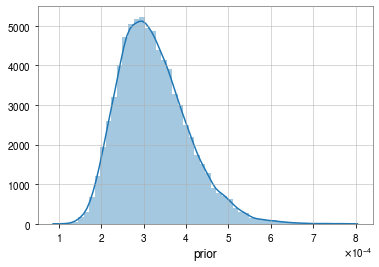

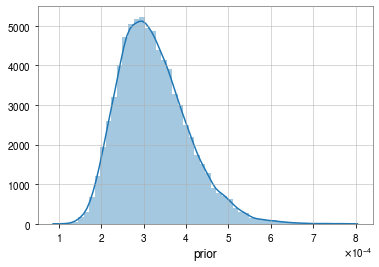

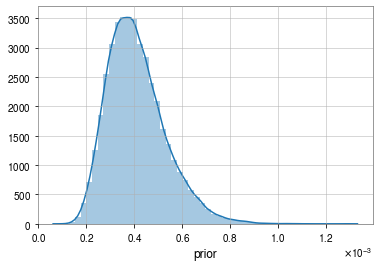

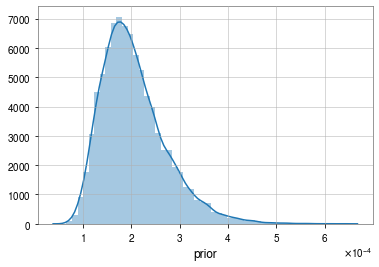

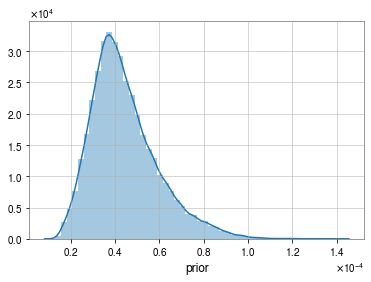

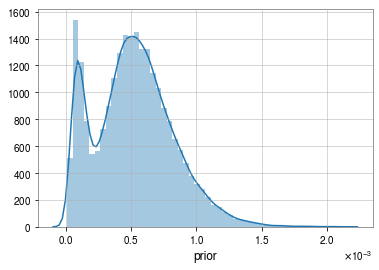

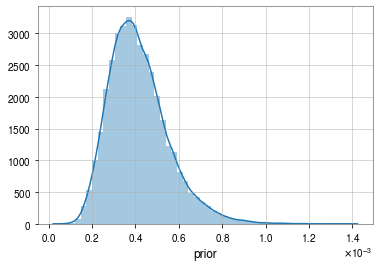

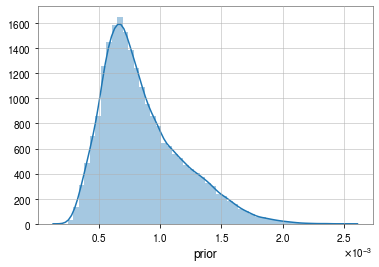

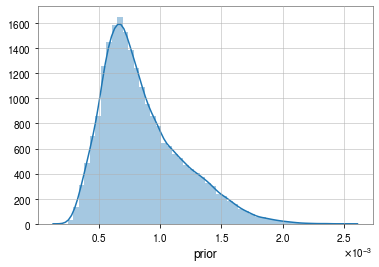

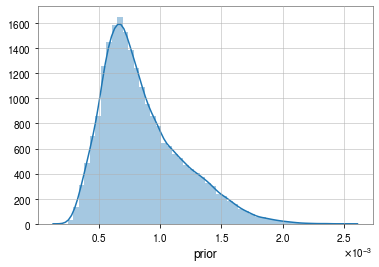

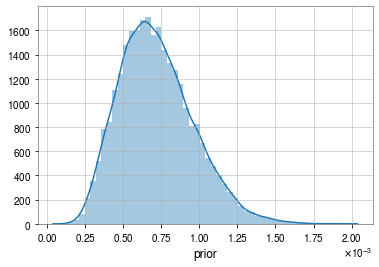

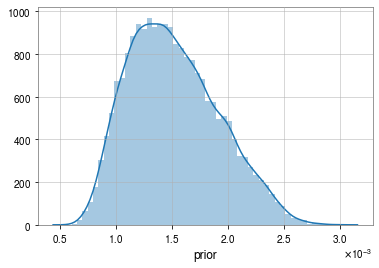

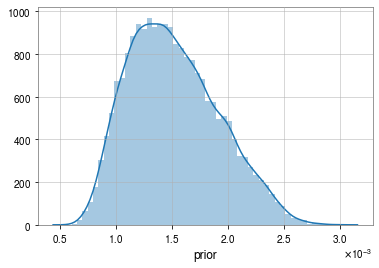

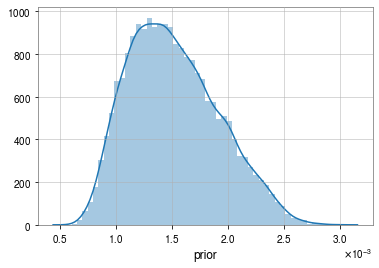

In [10]:
for posterior in posteriors:
    sns.distplot(posterior["prior"], bins = 50)
    plt.show()

### Calculation

In [11]:
from gwpopulation.utils import beta_dist, truncnorm


def modelA(dataset, xi_spin, sigma_spin, amax, alpha_chi, beta_chi):
    """
    Independently and identically distributed spins.
    """
    prior = iid_spin_orientation_gaussian_isotropic(
        dataset, xi_spin, sigma_spin
    ) * iid_spin_magnitude_beta(dataset, amax, alpha_chi, beta_chi)
    return prior


def iid_spin_magnitude_beta(dataset, amax=1, alpha_chi=1, beta_chi=1):
    """
    Independently and identically distributed spin magnitudes.
    """
    return independent_spin_magnitude_beta(
        dataset, alpha_chi, alpha_chi, beta_chi, beta_chi, amax, amax
    )


def independent_spin_magnitude_beta(
    dataset, alpha_chi_1, alpha_chi_2, beta_chi_1, beta_chi_2, amax_1, amax_2
):
    """ Independent beta distributions for both spin magnitudes.
    https://arxiv.org/abs/1805.06442 Eq. (10)
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html
    Parameters
    ----------
    dataset: dict
        Dictionary of numpy arrays containing 'a_1' and 'a_2'.
    alpha_chi_1, beta_chi_1: float
        Parameters of Beta distribution for more massive black hole.
    alpha_chi_2, beta_chi_2: float
        Parameters of Beta distribution for less massive black hole.
    amax_1, amax_2: float
        Maximum spin of the more/less massive black hole.
    """
    if alpha_chi_1 <= 1 or beta_chi_1 <= 1 or alpha_chi_2 <= 1 or beta_chi_2 <= 1:
        return 0
    else: 
        prior = beta_dist(dataset["a_1"], alpha_chi_1, beta_chi_1, scale=amax_1) * beta_dist(dataset["a_2"], alpha_chi_2, beta_chi_2, scale=amax_2)
        return prior


def iid_spin_orientation_gaussian_isotropic(dataset, xi_spin, sigma_spin):
    """
    Independently and identically distributed spin orientations.
    """
    return independent_spin_orientation_gaussian_isotropic(
        dataset, xi_spin, sigma_spin, sigma_spin
    )


def independent_spin_orientation_gaussian_isotropic(dataset, xi_spin, sigma_1, sigma_2):
    """A mixture model of spin orientations with isotropic and normally
    distributed components.
    https://arxiv.org/abs/1704.08370 Eq. (4)
    Parameters
    ----------
    dataset: dict
        Dictionary of numpy arrays for 'cos_tilt_1' and 'cos_tilt_2'.
    xi_spin: float
        Fraction of black holes in preferentially aligned component.
    sigma_1: float
        Width of preferentially aligned component for the more
        massive black hole.
    sigma_2: float
        Width of preferentially aligned component for the less
        massive black hole.
    """
    prior = (1 - xi_spin) / 4 + xi_spin * truncnorm(
        dataset["cos_tilt_1"], 1, sigma_1, 1, -1
    ) * truncnorm(dataset["cos_tilt_2"], 1, sigma_2, 1, -1)
    return prior


# modelA = bilby.hyper.model.Model([spin.iid_spin])

In [12]:
def mu_chi_var_chi_max_to_alpha_beta_max(mu_chi, var_chi, amax):
    """
    Convert between parameters for beta distribution
    """
    mu_chi /= amax
    var_chi /= amax**0.5
    alpha = (mu_chi ** 2 * (1 - mu_chi) - mu_chi * var_chi) / var_chi
    beta = (mu_chi * (1 - mu_chi) ** 2 - (1 - mu_chi) * var_chi) / var_chi
    return alpha, beta


def prior_conversion(parameters):
    
    """Wrapper around conversion for prior constraints"""
    parameters = parameters.copy()
    added_keys = None
    parameters["amax"] = 1
    alpha, beta = mu_chi_var_chi_max_to_alpha_beta_max(parameters["mu_chi"], parameters["var_chi"], parameters["amax"])
    parameters["alpha_chi"] = alpha
    parameters["beta_chi"] = beta
    return parameters, added_keys

In [13]:
priorsA = PriorDict(conversion_function = prior_conversion)

# spin magnitude 
priorsA["mu_chi"] = Uniform(minimum = 0, maximum = 1, latex_label = '$\\mu_{\\chi}$')
priorsA["var_chi"] = Uniform(minimum = 0, maximum = 0.25, latex_label = '$\\sigma_{\\chi}^2$')
priorsA["alpha_chi"] = Constraint(minimum = 1, maximum = 1e5)
priorsA["beta_chi"] = Constraint(minimum = 1, maximum = 1e5)

# spin orientation
priorsA["xi_spin"] = Uniform(minimum = 0, maximum = 1, latex_label='$\\zeta$')
priorsA["sigma_spin"] = Uniform(minimum = 0.1, maximum = 4, latex_label='$\\sigma_{t}$')

In [14]:
likelihoodA = gwpop.hyperpe.HyperparameterLikelihood(posteriors = posteriors, 
                                                     hyper_prior = modelA,
                                                     conversion_function = prior_conversion)

In [15]:
for ii in range(10):
    likelihoodA.parameters.update(priorsA.sample())
    print(likelihoodA.parameters)
    print(likelihoodA.log_likelihood_ratio())

{'mu_chi': 0.08774796527945117, 'var_chi': 0.10478092742771225, 'xi_spin': 0.3335525453184136, 'sigma_spin': 3.417335006655943}
-1.7976931348623157e+308
{'mu_chi': 0.7905783359257638, 'var_chi': 0.15900484480346333, 'xi_spin': 0.1597926063088232, 'sigma_spin': 0.9193798623956861, 'amax': 1, 'alpha_chi': -0.020712178327756615, 'beta_chi': -0.2153295151952156}
-1.7976931348623157e+308
{'mu_chi': 0.3772059339437551, 'var_chi': 0.020302282563054497, 'xi_spin': 0.3720954068181952, 'sigma_spin': 3.320890877989318, 'amax': 1, 'alpha_chi': 0.03261352436001717, 'beta_chi': 0.008639217940120476}
274.4176037512884
{'mu_chi': 0.9963490724888409, 'var_chi': 0.1185292665105726, 'xi_spin': 0.17190838867878755, 'sigma_spin': 1.639584506043759, 'amax': 1, 'alpha_chi': 3.987516495547376, 'beta_chi': 6.58367588697212}
-1.7976931348623157e+308
{'mu_chi': 0.21378272936955645, 'var_chi': 0.09230683477058149, 'xi_spin': 0.3886066265396988, 'sigma_spin': 1.6307277277969767, 'amax': 1, 'alpha_chi': -0.96577166

In [16]:
likelihoodA.parameters.update(priorsA.sample())
likelihoodA.log_likelihood_ratio()

-1.7976931348623157e+308

In [17]:
resultA = bilby.run_sampler(likelihood = likelihoodA, priors = priorsA, sampler='dynesty', 
                            nlive = 200, label='d1-mass', outdir = 'd1-mass', clean = True)

17:37 bilby INFO    : Running for label 'd1-mass', output will be saved to 'd1-mass'
17:37 bilby WARNING : Parameter amax has no default prior and is set to 1, this will not be sampled and may cause an error.
17:37 bilby INFO    : Search parameters:
17:37 bilby INFO    :   mu_chi = Uniform(minimum=0, maximum=1, name=None, latex_label='$\\mu_{\\chi}$', unit=None, boundary=None)
17:37 bilby INFO    :   var_chi = Uniform(minimum=0, maximum=0.25, name=None, latex_label='$\\sigma_{\\chi}^2$', unit=None, boundary=None)
17:37 bilby INFO    :   xi_spin = Uniform(minimum=0, maximum=1, name=None, latex_label='$\\zeta$', unit=None, boundary=None)
17:37 bilby INFO    :   sigma_spin = Uniform(minimum=0.1, maximum=4, name=None, latex_label='$\\sigma_{t}$', unit=None, boundary=None)
17:37 bilby INFO    :   alpha_chi = Constraint(minimum=1, maximum=100000.0, name=None, latex_label=None, unit=None)
17:37 bilby INFO    :   beta_chi = Constraint(minimum=1, maximum=100000.0, name=None, latex_label=None, u

0it [00:00, ?it/s]

17:37 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 200, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 120, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f4dbda8d730>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
17:37 bilby INFO    : Checkpoint every check_point_delta_t = 600s
17:37 bilby INFO    : Using dynesty version 1.0.1
17:37 bilby INFO    : Generating initial points from the pri

450it [05:59,  1.17s/it, bound:318 nc:178 ncall:5.9e+04 eff:0.8% logz-ratio=274.75+/-0.11 dlogz:5.567>0.1]

17:43 bilby INFO    : Written checkpoint file d1-mass/d1-mass_resume.pickle


1032it [16:00,  1.05s/it, bound:899 nc:171 ncall:1.6e+05 eff:0.6% logz-ratio=277.23+/-0.16 dlogz:1.252>0.1]

17:53 bilby INFO    : Written checkpoint file d1-mass/d1-mass_resume.pickle
17:53 bilby INFO    : Writing 164 current samples to d1-mass/d1-mass_samples.dat


1644it [24:35,  1.49it/s, bound:1435 nc:131 ncall:2.4e+05 eff:0.7% logz-ratio=277.73+/-0.17 dlogz:0.100>0.1]

18:02 bilby INFO    : Written checkpoint file d1-mass/d1-mass_resume.pickle
18:02 bilby INFO    : Writing 761 current samples to d1-mass/d1-mass_samples.dat


1644it [24:39,  1.11it/s, bound:1435 nc:  1 ncall:2.4e+05 eff:0.8% logz-ratio=277.77+/-0.18 dlogz:0.001>0.1]

18:02 bilby INFO    : Sampling time: 0:24:27.370383


18:02 bilby INFO    : Summary of results:
nsamples: 1844
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.184
ln_bayes_factor: 277.774 +/-  0.184



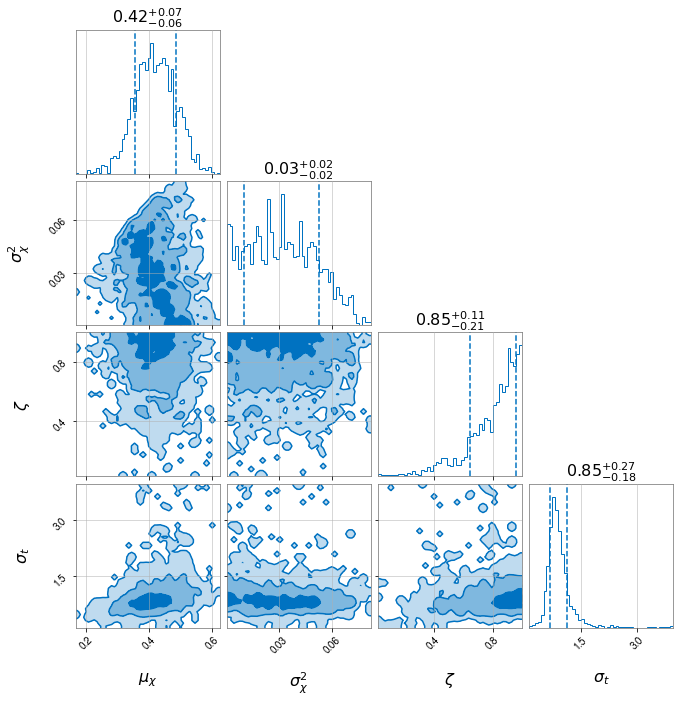

In [18]:
resultA.plot_corner()

### Post processing

In [ ]:
# resultA = bilby.core.result.read_in_result(d1/d1_result.json)

In [19]:
resultA.posterior["log_likelihood"].max()

283.6779562334482

In [1]:
pd = resultA.posterior
pd

NameError: name 'resultA' is not defined

In [31]:
alpha, beta = mu_chi_var_chi_max_to_alpha_beta_max(pd["mu_chi"], pd["var_chi"], 1)
pd["alpha_chi"] = alpha
pd["beta_chi"] = beta
pd

,mu_chi,var_chi,xi_spin,sigma_spin,log_likelihood,log_prior,alpha_chi,beta_chi
0,0.307778,0.001952,0.501264,3.793185,-1.245475,1.13398,33.289783,74.871953
1,0.234178,0.080490,0.052851,3.418169,-0.586331,1.13398,0.287592,0.940496
2,0.473136,0.068717,0.331817,0.218258,-0.237970,1.13398,1.243211,1.384388
3,0.544370,0.066949,0.568663,0.594855,0.079396,1.13398,1.472406,1.232384
4,0.599803,0.040596,0.488922,1.220950,0.189740,1.13398,2.946775,1.966127
...,...,...,...,...,...,...,...,...
4560,0.309925,0.042305,0.986227,0.757251,8.756308,1.13398,1.256891,2.798571
4561,0.330031,0.049439,0.984392,0.795275,8.781883,1.13398,1.146010,2.326419
4562,0.333944,0.049668,0.991769,0.817384,8.797655,1.13398,1.161539,2.316707
4563,0.312432,0.045615,0.993558,0.799399,8.829097,1.13398,1.158915,2.550422


In [33]:
pd["alpha_chi"].min()

0.28107922701691035